In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import h5py
import os
import os.path as osp
from tqdm.notebook import tqdm

# === USER INPUTS ===
backend_dir =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/")  # <- replace with your emcee backend file
files = [f for f in os.listdir(backend_dir) if 'run' and 'Cs' and 'bc_run' in f]
files = [f for f in files if 'temp' not in f]
files

['bc_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse.h5',
 'bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_BC_hierarchy.h5',
 'bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5',
 'bc_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_BC_hierarchy.h5',
 'bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecFalse_dTTrue_covFalse.h5',
 'bc_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5',
 'bc_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5']

Loaded backend with 64 walkers and 12000 steps.
Autocorrelation times (steps): [428.19351274 566.57120797 381.08696513 393.35065735 320.51859045
 482.0623699  452.9605365 ]


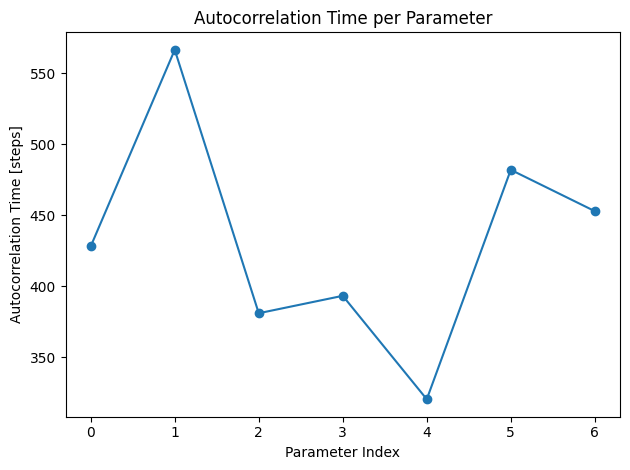

In [2]:
backend_file = backend_dir+files[1]
# backend_file = backend_dir+'full_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5'
# backend_file = backend_dir+'full_run_Cs_ATrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_AFalse_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTFalse_covTrue.h5'
# backend_file = backend_dir+'full_run.h5'
discard = 0  # number of burn-in steps to discard
thin = 10      # thinning factor for chains
flat = True    # whether to flatten the chain
max_autocorr_steps = 100  # how far to try computing autocorr
# ====================

# Load the backend
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
n_steps, n_walkers, n_dim = backend.get_chain().shape
print(f"Loaded backend with {n_walkers} walkers and {n_steps} steps.")

# Check if there's enough data
if n_steps < 2 * discard:
    raise RuntimeError("Too few samples to discard burn-in.")

# Compute autocorrelation time
try:
    tau = backend.get_autocorr_time(tol=0, discard=discard)
    print("Autocorrelation times (steps):", tau)
except emcee.autocorr.AutocorrError:
    print("WARNING: Autocorrelation time could not be reliably estimated. Showing partial results.")
    tau = None

# Plot autocorrelation estimate per parameter (if possible)
if tau is not None:
    fig, ax = plt.subplots()
    ax.plot(tau, "o-")
    ax.set_xlabel("Parameter Index")
    ax.set_ylabel("Autocorrelation Time [steps]")
    ax.set_title("Autocorrelation Time per Parameter")
    plt.tight_layout()
    plt.show()

In [3]:
acceptance_fraction = backend.accepted / backend.iteration
# acceptance_fraction
backend.accepted

array([3507., 3613., 3016., 3346., 2080., 3251., 2593., 3508., 3487.,
       3463., 3076., 3026., 3093., 3332., 3719., 3662., 3256., 3387.,
       3407., 3293., 3625., 3472., 3358., 3146., 2531., 3379., 2930.,
       3135., 3509., 3330., 3362., 3525., 3568., 3186., 3329., 3285.,
       3128., 3629., 3166., 3464., 3382., 3092., 3485., 3134., 3466.,
       3190.,  534., 3148., 3547., 3230., 3157., 3447., 3160., 3358.,
       3203., 3552., 3368., 3357., 3230., 3149., 3486., 3171., 2895.,
       3217.])

Loaded backend with 64 walkers, 12000 steps, 7 dimensions.


  0%|          | 0/1200 [00:00<?, ?it/s]

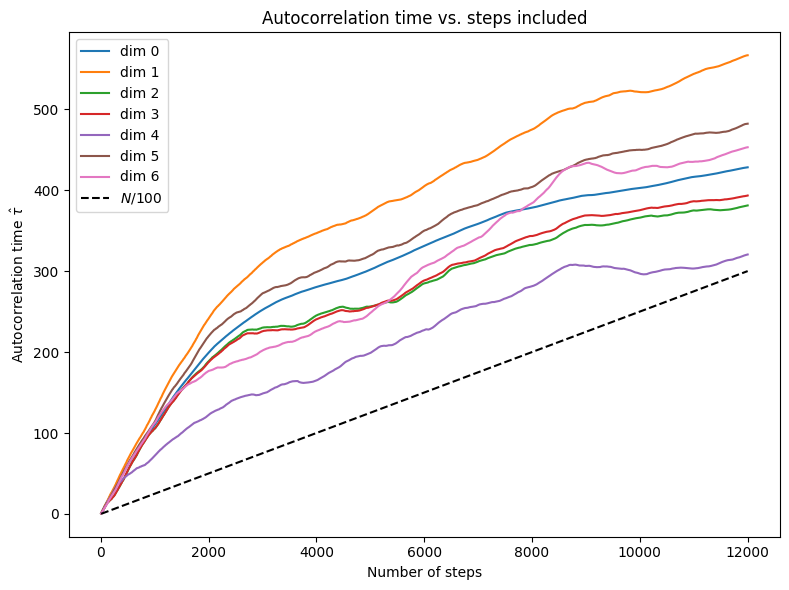

In [4]:
discard = 0
thin = 1
step_stride = 10
min_steps = 10

# ====================

# Load backend and chain
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
full_chain = backend.get_chain(discard=discard, thin=thin)
n_steps, n_walkers, n_dim = full_chain.shape
max_steps = n_steps+100
print(f"Loaded backend with {n_walkers} walkers, {n_steps} steps, {n_dim} dimensions.")

# Limit the max_steps to what's available
max_steps = min(max_steps, n_steps)

# Storage
all_taus = []
step_list = []

# Loop over truncated chains
for n in tqdm( range(min_steps, max_steps + 1, step_stride) ):
    truncated = full_chain[:n]  # shape (n, n_walkers, n_dim)
    try:
        tau = emcee.autocorr.integrated_time(truncated, tol=0)
        all_taus.append(tau)
        step_list.append(n)
    except emcee.autocorr.AutocorrError:
        print(f"Step {n}: autocorr failed")
        continue

# Convert to arrays
all_taus = np.array(all_taus)  # shape (num_points, ndim)
step_list = np.array(step_list)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_dim):
    ax.plot(step_list, all_taus[:, i], label=f"dim {i}")
ax.plot(step_list, step_list / 40, "--k", label=r"$N/100$")

ax.set_xlabel("Number of steps")
ax.set_ylabel(r"Autocorrelation time $\hat{\tau}$")
ax.set_title("Autocorrelation time vs. steps included")
ax.legend()
plt.tight_layout()
plt.show()


Samples shape: (685056, 7)


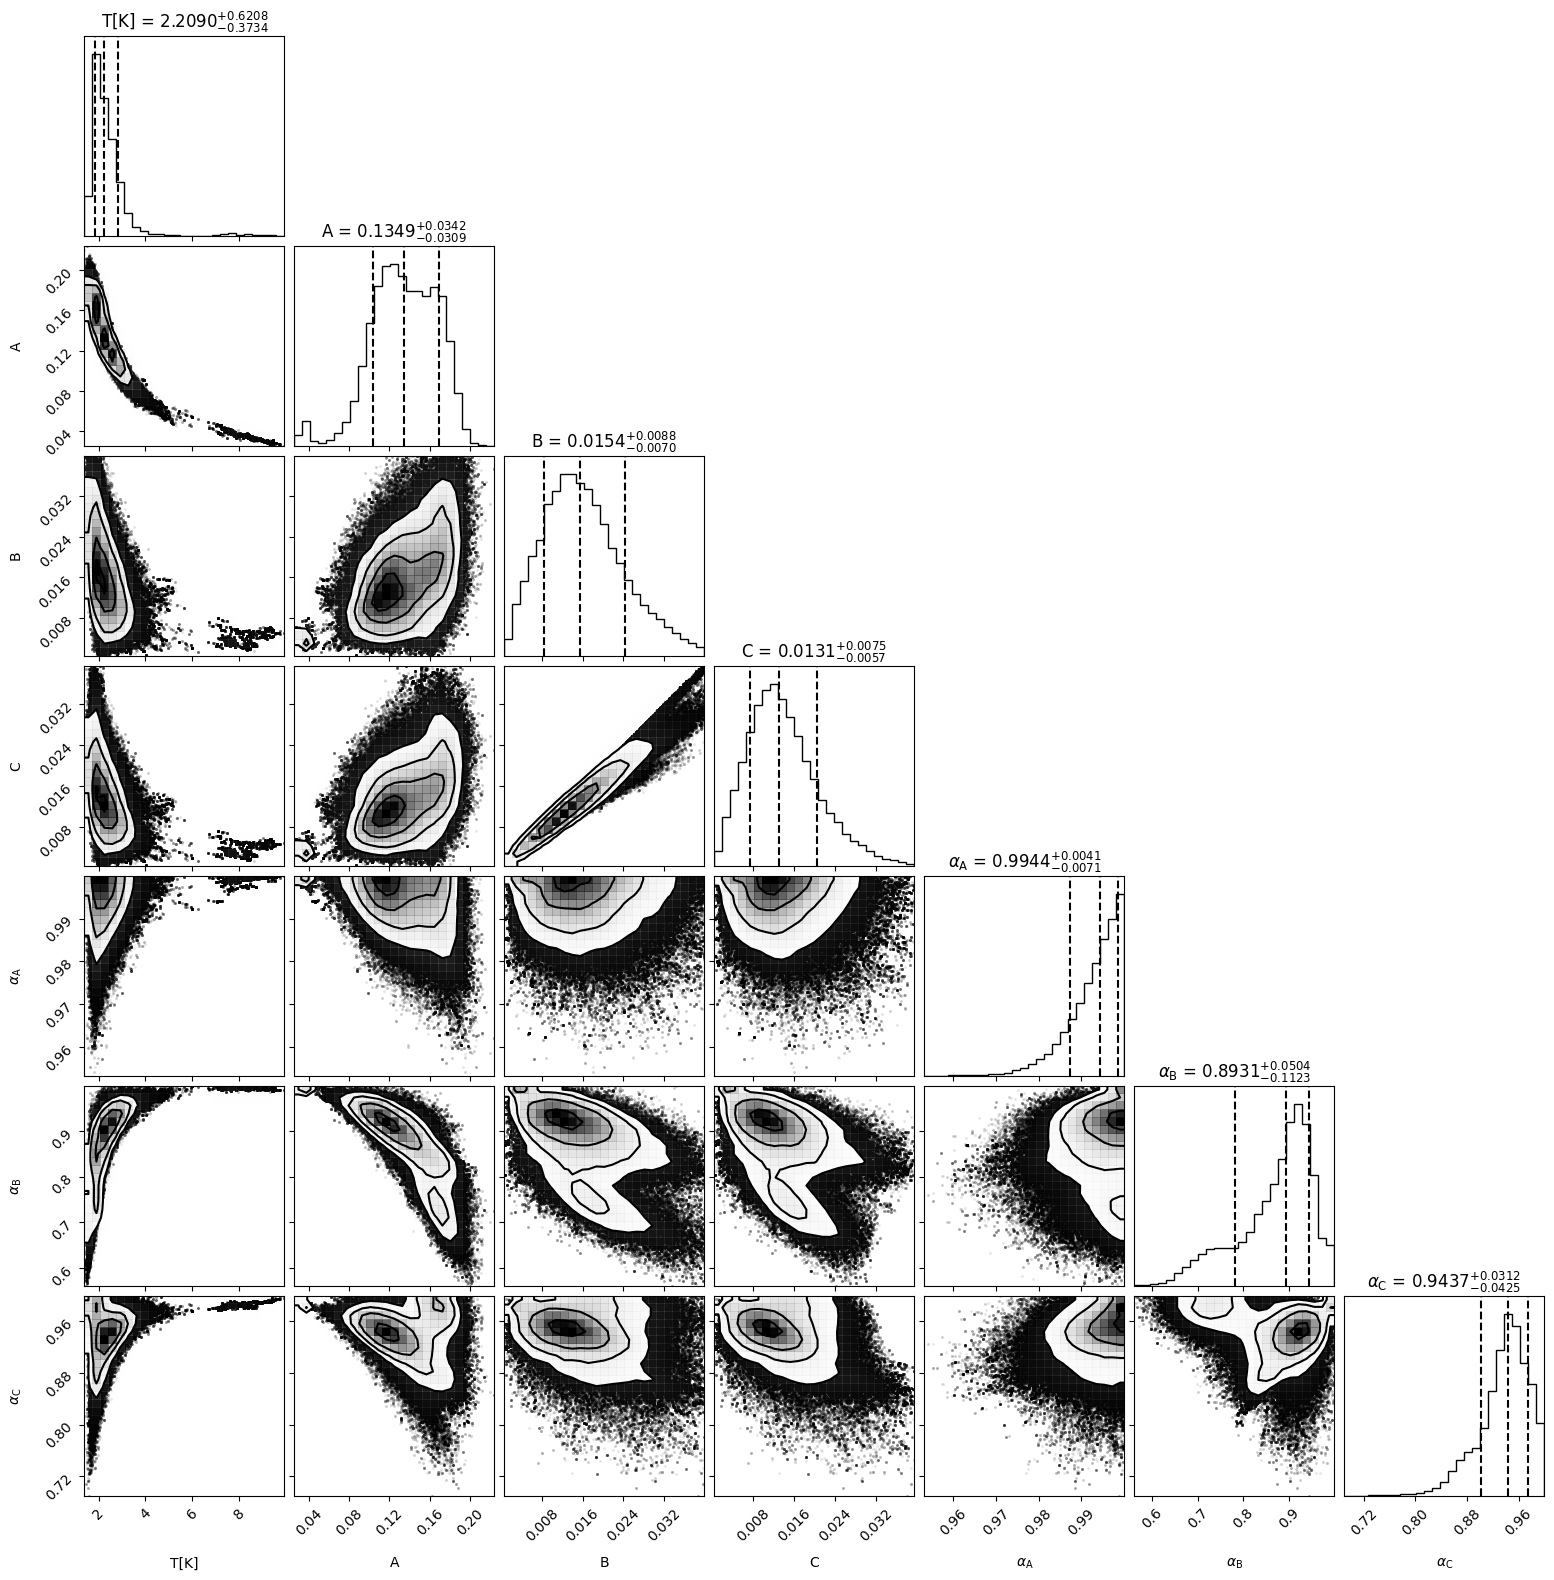

In [11]:
if n_dim == 5:
    # Extract samples
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)
    
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


if n_dim == 7:
    # Extract samples
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)

    # samples_ext = samples[samples[:,0]>10]
    # samples = np.vstack([samples, samples_ext, samples_ext, samples_ext])
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


In [6]:
if n_dim == 5:
    # Extract samples
    thin = 1
    discard = int( 5*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)

    samples = samples[samples[:,0]>10]
    
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


if n_dim == 7:
    # Extract samples
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)

    samples = samples[samples[:,0]>10]
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


Samples shape: (0, 7)


AssertionError: I don't believe that you want more dimensions than samples!

In [7]:
A = 0.0270
B = 0.0054
(1/(1/A+1/B) )

0.0045000000000000005

In [8]:
A = 0.1342
B = 0.0206
(1/(1/A+1/B) )

0.017858656330749356

In [15]:
A = 0.1342
B = 0.0206
B/(1/(1/A+1/B) )

1.1535022354694484

1.1635188125552602

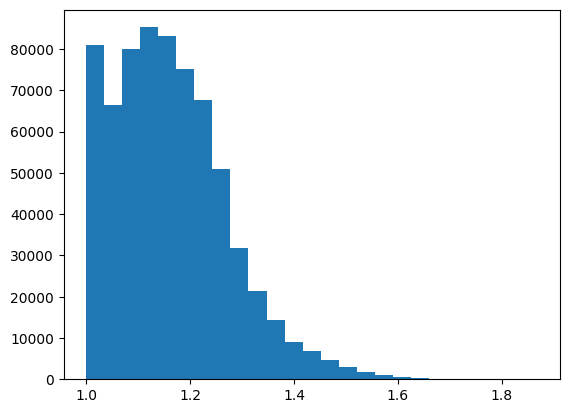

In [12]:
R = samples[:,2]/samples[:,3]
plt.hist(R, bins = 25);
np.mean(R)

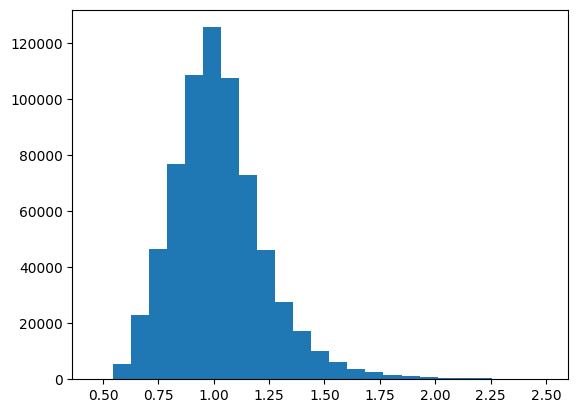

In [17]:
# plt.hist( samples[:,1]/samples[:,3] , bins = 25);
plt.hist( np.log10( samples[:,1]/samples[:,3] ), bins = 25);

In [26]:
# np.savetxt(osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/emcee_orig_2276.txt"), samples)
errs = h5py.File('jackknife_dib.h5', "r")
errs['cov']

<HDF5 dataset "cov": shape (143, 143, 4), type "<f8">

In [27]:

# === USER INPUTS ===

savetest = emcee.backends.HDFBackend(backend_file, read_only=True)
savetest, backend_file

(<emcee.backends.hdf.HDFBackend at 0x14db384e3880>,
 '/home/cj1223/../../scratch/gpfs/cj1223/DIB/bc_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse_BC_hierarchy.h5')

In [28]:
fudge = 1
DIB_15272 = h5py.File('new_errs/res_dib_15272.h5', "r")
data_wavelength = DIB_15272['wav'][:]
data_flux = DIB_15272['mean'][:][:,0]
data_flux_dT = DIB_15272['mean'][:][:,1]

noise_std = fudge*np.sqrt(DIB_15272['var'][:][:,0])
noise_std_dT = fudge*np.sqrt(DIB_15272['var'][:][:,1])

In [29]:
savetest.get_blobs()

array([[[-5.35497215e-01, -6.63452968e-01,  1.04364858e-02, ...,
         -1.14363020e+01, -8.74705573e+00,  5.63850490e-04],
        [-5.17947185e-01, -6.38979551e-01,  8.79127632e-03, ...,
         -1.14245777e+01, -9.30598714e+00,  4.40680862e-04],
        [-5.37435758e-01, -6.57302601e-01,  9.70470583e-03, ...,
         -1.27332389e+01, -9.43466436e+00,  4.91763655e-04],
        ...,
        [-5.81275047e-01, -7.25361973e-01,  1.36739514e-02, ...,
         -1.27697292e+01, -9.20276959e+00,  6.92903041e-04],
        [-5.81163354e-01, -7.13264271e-01,  1.27769391e-02, ...,
         -1.35183390e+01, -9.12901270e+00,  6.55780019e-04],
        [-6.03289241e-01, -7.44358824e-01,  1.43169151e-02, ...,
         -1.35566222e+01, -9.24204055e+00,  7.05475733e-04]],

       [[-5.04388527e-01, -6.07991102e-01,  7.47700641e-03, ...,
         -9.32811664e+00, -7.81578740e+00,  4.25599551e-04],
        [-5.17728910e-01, -6.38541839e-01,  8.76880279e-03, ...,
         -1.14116895e+01, -9.30509857e

In [30]:
savetest.get_log_prob()

array([[-132.15778335, -134.70693545, -142.32899783, ..., -170.17423977,
        -159.63991416, -180.68747509],
       [-102.80329125, -134.57808484, -142.32899783, ..., -170.99756863,
        -159.63991416, -180.68747509],
       [-102.80329125, -124.07002444, -138.58017052, ..., -170.99756863,
        -157.98863721, -178.38721109],
       ...,
       [ -50.07689382,  -47.76062369,  -46.88485806, ...,  -50.18653445,
         -48.29239182,  -47.2425507 ],
       [ -50.07689382,  -47.76062369,  -47.70119084, ...,  -50.18653445,
         -51.76166474,  -47.2425507 ],
       [ -50.19460412,  -47.76062369,  -47.70119084, ...,  -50.18653445,
         -51.76166474,  -47.2425507 ]])

In [31]:
np.std(savetest.get_log_prob(), axis = 0)

array([2.99238723, 3.34400704, 4.0622668 , 3.89973174, 4.00466906,
       4.44124575, 4.71921919, 3.47734589, 5.17852999, 4.00989143,
       3.83882053, 5.04740503, 4.26064505, 3.80567214, 4.68917852,
       3.67162202, 3.54183147, 4.03439773, 4.20618264, 5.2491271 ,
       4.42561631, 4.89579113, 3.49356337, 4.5590418 , 3.5399794 ,
       3.25416173, 3.95037233, 4.91575106, 4.07304811, 3.31137332,
       4.62299178, 5.33478863, 2.66900358, 4.2358961 , 4.24321237,
       3.49396475, 4.42080649, 3.8520658 , 3.87620766, 3.26899909,
       4.13338017, 3.59565589, 3.24252298, 2.75622142, 5.04209204,
       4.62287236, 4.19868019, 3.43451014, 2.93723174, 4.14133869,
       4.27421387, 3.50191453, 4.23840611, 5.03319157, 3.36935334,
       4.32823553, 3.56765244, 3.75216522, 4.13141591, 3.93316168,
       3.93270191, 5.19099567, 4.30089263, 4.2665502 ])

In [32]:
savetest.accepted

array([3507., 3613., 3016., 3346., 2080., 3251., 2593., 3508., 3487.,
       3463., 3076., 3026., 3093., 3332., 3719., 3662., 3256., 3387.,
       3407., 3293., 3625., 3472., 3358., 3146., 2531., 3379., 2930.,
       3135., 3509., 3330., 3362., 3525., 3568., 3186., 3329., 3285.,
       3128., 3629., 3166., 3464., 3382., 3092., 3485., 3134., 3466.,
       3190.,  534., 3148., 3547., 3230., 3157., 3447., 3160., 3358.,
       3203., 3552., 3368., 3357., 3230., 3149., 3486., 3171., 2895.,
       3217.])

In [33]:
from multiprocessing import get_context
import subprocess, os, emcee, time, shutil, h5py, argparse
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import os.path as osp
from pathlib import Path
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.interpolate import interp1d

# Constants
PGO_TEMPLATE = "asym_top_15272_Cs.pgo"

# Compose TEMP_SUFFIX and TEMP_DIR depending on all args
def val_to_str(v):
    if isinstance(v, bool):
        return "True" if v else "False"
    elif isinstance(v, float):
        return str(v).replace('.', 'p')
    return str(v)
    
def filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C, axis = 'b'):
    return f"T{T:.3f}_A{A_base:.7f}_B{B_base:.7f}_C{C_base:.7f}_FA{frac_A:.5f}_FB{frac_B:.5f}_FC{frac_C:.5f}_ax{axis}"

def generate_pgopher_input(T, A_base, B_base, C_base, frac_A, frac_B, frac_C, axis="b"):
    A_g, B_g, C_g = A_base, B_base, C_base
    A_e, B_e, C_e = A_base * frac_A, B_base * frac_B, C_base * frac_C

    base = filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C, axis = axis)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" \\
        -v axis="{axis}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    /<CartesianTransitionMoment Axis="/ {{
        sub(/Axis="[^"]+"/, "Axis=\\"" axis "\\"")
    }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")
    subprocess.run(["./pgo", "--plot", pgo_file, spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def convolve_pgopher_spectrum(spectrum_file, center_wav, lsf_key='LCO+APO', dlam=0.01, window=8):
    """
    Convolve PGOPHER output using LSF evaluated on a regular wavelength grid.

    Parameters:
        spectrum_file (str): PGOPHER output file with [wavenumber (1/cm), flux].
        center_wav (float): Central wavelength for the LSF (Å).
        lsf_key (str): Instrument profile selector (placeholder).
        dlam (float): Spacing (Å) for the regular wavelength grid.
        window (float): Half-width (Å) of the wavelength region to define the regular grid.

    Returns:
        wav_lsf (np.ndarray): Wavelength grid used for final output.
        flux_on_lsf_grid (np.ndarray): Flux convolved and resampled to wav_lsf.
        lsf_kernel (np.ndarray): LSF evaluated on regular grid.
        wav_pgo (np.ndarray): Original PGOPHER wavelength grid.
        convolved_flux (np.ndarray): Full-resolution convolved flux (on regular grid).
    """
    # === Load PGOPHER spectrum ===
    inv_cm, flux = np.loadtxt(spectrum_file).T
    wav_pgo = 1e8 / inv_cm

    wavc = 15272.27178113337
    # === Define regular wavelength grid around center ===
    wav_reg = np.arange(wavc - window, wavc + window, dlam)

    # === Interpolate PGOPHER flux onto this regular grid ===
    flux_interp = interp1d(wav_pgo, flux, bounds_error=False, fill_value=0.0)
    flux_reg = flux_interp(wav_reg)

    # === Construct LSF kernel on regular grid ===
    sig1 = 0.3
    sig2 = 1.85 * sig1
    sig3 = 9.5 * sig1
    f1 = 0.895
    f2 = 0.1
    c0 = 1.3e-3

    rel_grid = wav_reg - wavc  # Center the kernel
    p1 = 1/np.sqrt(2*np.pi*sig1**2)*np.exp( - rel_grid**2 / (2 * sig1**2) )
    p2 = 1/np.sqrt(2*np.pi*sig2**2)*np.exp( - rel_grid**2 / (2 * sig2**2) )
    p3 = 1/np.sqrt(2*np.pi*sig3**2)*np.exp( - rel_grid**2 / (2 * sig3**2) )

    lsf_kernel = f1 * p1 + f2 * p2 + (1 - f1 - f2) * p3 + c0
    lsf_kernel /= np.sum(lsf_kernel)

    # === Convolve on regular grid ===
    convolved_flux = convolve(flux_reg, lsf_kernel, mode='same')

    # === Interpolate back to original PGOPHER (or LSF) grid ===
    out_interp = interp1d(wav_reg, convolved_flux, bounds_error=False, fill_value=0.0)

    lsf_file = f'LSFs/lsf_15272.h5'
    # Load LSF and its wavelength grid
    with h5py.File(lsf_file, 'r') as f:
        wav_load = f['wav'][:]
      # Or replace with another grid if desired
    flux_on_lsf_grid = out_interp(wav_load)

    return wav_load, flux_on_lsf_grid

def log_prior(params):
    if args.B_not_equal_C:
        if len(params) != 7:
            return -np.inf
        T, A, B, C, frac_A, frac_B, frac_C = params
    else:
        if len(params) != 5:
            return -np.inf
        T, A, C, frac_A, frac_C = params
        B = A
        frac_B = frac_A

    if args.flat_prior:
        if not (3 <= T <= 100): return -np.inf
        if not (0.0001 <= C <= 0.02): return -np.inf
        if not (0.0001 <= B <= 0.02): return -np.inf
        if not (0.0001 <= A <= 0.2): return -np.inf
        if not (0.9 <= frac_A <= 1.0): return -np.inf
        if not (0.9 <= frac_B <= 1.0): return -np.inf
        if not (0.9 <= frac_C <= 1.0): return -np.inf
        return 0.0
    else:
        if T <= 2 or T > 100: return -np.inf
        ## params for log-normal Temp prior
        mu = np.log(30)
        sigma = 1
        temp_logprior = -np.log(T * sigma * np.sqrt(2 * np.pi)) - ((np.log(T) - mu) ** 2) / (2 * sigma ** 2)

        if C < 0.0005 or C > 0.04: return -np.inf
        if B < 0.0005 or B > 0.04: return -np.inf
        ab_logprior = 0.0

        if A < 0.001 or A > 0.2: return -np.inf
        c_logprior = 0.0

        if frac_A > 1: return -np.inf
        frac_a_logprior = -10 * (frac_A - 1) ** 2

        if frac_B > 1: return -np.inf
        frac_b_logprior = -10 * (frac_B - 1) ** 2

        if frac_C > 1: return -np.inf
        frac_c_logprior = -10 * (frac_C - 1) ** 2

        return temp_logprior + ab_logprior + c_logprior + frac_a_logprior + frac_b_logprior + frac_c_logprior

def compute_loglikelihood(
    model_flux_b, model_flux_c,
    model_flux_dT_b, model_flux_dT_c,
    data_flux, data_flux_dT,
    noise_std, noise_std_dT
):
    chi2 = 0.0
    c = 10  # edge crop
    gf = 0.01  # Gaussian filter width
    b_frac = c_frac = offset = 0
    b_frac_dT = c_frac_dT = offset_dT = 0
    base_frac_dT = 0

    # Apply Gaussian filter and crop edges
    spec_b = gaussian_filter(model_flux_b[c:-c], gf)
    spec_c = gaussian_filter(model_flux_c[c:-c], gf)
    measurement = data_flux[c:-c]
    noise = noise_std[c:-c]

    # Fit linear combination: b_frac * spec_b + c_frac * spec_c + offset
    M = np.vstack([spec_b, spec_c, np.ones_like(spec_b)]).T
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
    b_frac, c_frac, offset = coeffs

    # Evaluate fit
    fit = b_frac * spec_b + c_frac * spec_c + offset
    chi = (measurement - fit) / noise
    chi2 += np.sum(chi ** 2)


    # Apply Gaussian filter and crop edges
    spec_b = gaussian_filter(model_flux_b[c:-c], gf)
    spec_c = gaussian_filter(model_flux_c[c:-c], gf)
    spec_dT_b = gaussian_filter(model_flux_dT_b[c:-c], gf) - spec_b
    spec_dT_c = gaussian_filter(model_flux_dT_c[c:-c], gf) - spec_c
    measurement_dT = data_flux_dT[c:-c]
    noise_dT = noise_std_dT[c:-c]

    # Estimate direct ratio to construct the base spectrum
    if args.fit_spec:
        ratio_direct = b_frac / (c_frac + 1e-10)
    else:
        ratio_direct = 1.0  # fallback

    # Form matrix: linear combo of original + delta spectra
    base_spec = spec_b + ratio_direct * spec_c
    M_dT = np.vstack([base_spec, spec_dT_b, spec_dT_c, np.ones_like(base_spec)]).T
    coeffs_dT, _, _, _ = np.linalg.lstsq(M_dT, measurement_dT, rcond=None)
    base_frac_dT, b_frac_dT, c_frac_dT, offset_dT = coeffs_dT

    # Evaluate fit
    fit_dT = (
        base_frac_dT * base_spec +
        b_frac_dT * spec_dT_b +
        c_frac_dT * spec_dT_c +
        offset_dT
    )
    chi_dT = (measurement_dT - fit_dT) / noise_dT
    chi2 += np.sum(chi_dT ** 2)

    # Optional: ratio constraint on the shape of the delta contributions
    ratio_dT = b_frac_dT / (c_frac_dT + 1e-10)
    ratio_tol = 0.5 * ratio_direct
    ratio_deviation = ((ratio_dT - ratio_direct) / ratio_tol) ** 2
    chi2 += ratio_deviation

    scalars = np.array([
    float(b_frac), float(c_frac), float(offset),
    float(base_frac_dT), float(b_frac_dT), float(c_frac_dT), float(offset_dT)])

    return -0.5 * chi2, scalars, fit, fit_dT

def model_log_likelihood(params, data_wavelength, data_flux, data_flux_dT, noise_std, noise_std_dT, central_wav = 15272):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, np.zeros(7)

    try:
        if args.B_not_equal_C:
            T, A, B, C, frac_A, frac_B, frac_C = params
        else:
            T, A, C, frac_A, frac_C = params
            B = A
            frac_B = frac_A
        
        
        spec_txt_b, base_b = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C, axis='b')
        _, model_flux_b = convolve_pgopher_spectrum(spec_txt_b, central_wav)

        spec_txt_c, base_c = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C, axis='c')
        _, model_flux_c = convolve_pgopher_spectrum(spec_txt_c, central_wav)

        if args.fit_dT:
            spec_txt_dT_b, base_dT_b = generate_pgopher_input(T + 0.05, A, B, C, frac_A, frac_B, frac_C, axis='b')
            _, model_flux_dT_b = convolve_pgopher_spectrum(spec_txt_dT_b, central_wav)

            spec_txt_dT_c, base_dT_c = generate_pgopher_input(T + 0.05, A, B, C, frac_A, frac_B, frac_C, axis='c')
            _, model_flux_dT_c = convolve_pgopher_spectrum(spec_txt_dT_c, central_wav)
        else:
            model_flux_dT_b = np.zeros_like(data_flux)
            model_flux_dT_c = np.zeros_like(data_flux)

        lnlike, scalars = compute_loglikelihood(
                model_flux_b, model_flux_c,
                model_flux_dT_b, model_flux_dT_c,
                data_flux, data_flux_dT,
                noise_std, noise_std_dT)

        if args.fit_spec:
            for spec_txt in [spec_txt_b, spec_txt_c]:
                base = osp.basename(spec_txt)  # e.g. spec_T20.005_A0.0026984_...txt
                if base.startswith("spec_") and base.endswith(".txt"):
                    param_str = base[len("spec_"):-len(".txt")]  # strip prefix/suffix
                    temp_pgo_file = os.path.join(TEMP_DIR, f'temp_{param_str}.pgo')

                    # Clean up
                    os.remove(spec_txt)
                    os.remove(temp_pgo_file)

        if args.fit_dT:
            for spec_txt_dT in [spec_txt_dT_b, spec_txt_dT_c]:
                base_dT = osp.basename(spec_txt_dT)
                if base_dT.startswith("spec_") and base_dT.endswith(".txt"):
                    param_str = base_dT[len("spec_"):-len(".txt")]
                    temp_pgo_file_dT = os.path.join(TEMP_DIR, f'temp_{param_str}.pgo')

                    # Clean up
                    os.remove(spec_txt_dT)
                    os.remove(temp_pgo_file_dT)

        return lnlike + lp, scalars

    except Exception as e:
        print(f"Error for params {params}: {e}")
        return -np.inf, np.zeros(7)

In [40]:
import numpy as np
import h5py
import os.path as osp
from tqdm import tqdm
from types import SimpleNamespace
import re

def parse_args_from_filename(filename):
    match = re.search(
        r"BC(?P<B_not_equal_C>True|False)_"
        r"F(?P<fudge>[\dp]+)_"
        r"D(?P<direct>True|False)_"
        r"Flat(?P<flat_prior>True|False)_"
        r"Spec(?P<fit_spec>True|False)_"
        r"dT(?P<fit_dT>True|False)_"
        r"cov(?P<covariance>True|False)",
        filename
    )

    if not match:
        raise ValueError("Filename format doesn't match expected pattern")

    args = match.groupdict()

    # Convert types
    args['B_not_equal_C'] = args['B_not_equal_C'] == "True"
    args['fudge'] = float(args['fudge'].replace('p', '.'))
    for key in ['direct', 'flat_prior', 'fit_spec', 'fit_dT', 'covariance']:
        args[key] = args[key] == "True"

    return args

# Use as dict

idx = 1
filename = files[idx]
backend_file = backend_dir+files[idx]

parsed_args = parse_args_from_filename(filename)

# Or convert to a Namespace-like object
args = SimpleNamespace(**parsed_args)

print(args)

TEMP_SUFFIX = files[idx][:-3]        
TEMP_DIR = osp.expanduser(f"~/../../scratch/gpfs/cj1223/DIB/pgo_temppy_{TEMP_SUFFIX}")
os.makedirs(TEMP_DIR, exist_ok=True)
shutil.rmtree(TEMP_DIR, ignore_errors=False, onerror=None)
os.makedirs(TEMP_DIR, exist_ok=True)

# === Load Samples from Backend ===
reader = emcee.backends.HDFBackend(backend_file)
samples = reader.get_chain(discard=1000, thin=10, flat=True)  # Adjust as needed
blobs = reader.get_blobs(discard=1000, thin=10, flat=True)

# === Choose N posterior samples ===
N = 20  # or whatever number you want
inds = np.random.choice(len(samples), size=N, replace=False)
posterior_samples = samples[inds]

# === Generate Spectra ===
posterior_spectra = []
posterior_dT = []
central_wav = 15272
deltaT = 0.05
fit_params = []
for i, params in tqdm(enumerate(posterior_samples), total=N, desc="Generating posterior spectra"):
    if not args.B_not_equal_C:
        # Expand to 7D by copying A to B and frac_A to frac_B
        T, A, C, frac_A, frac_C = params
        B = A
        frac_B = frac_A
        params = [T, A, B, C, frac_A, frac_B, frac_C]
    
    T, A, B, C, frac_A, frac_B, frac_C = params

    try:
        spec_txt_b, base_b = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C, axis='b')
        _, model_flux_b = convolve_pgopher_spectrum(spec_txt_b, central_wav)

        spec_txt_c, base_c = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C, axis='c')
        _, model_flux_c = convolve_pgopher_spectrum(spec_txt_c, central_wav)

    
        spec_txt_dT_b, base_dT_b = generate_pgopher_input(T + deltaT, A, B, C, frac_A, frac_B, frac_C, axis='b')
        _, model_flux_dT_b = convolve_pgopher_spectrum(spec_txt_dT_b, central_wav)

        spec_txt_dT_c, base_dT_c = generate_pgopher_input(T + deltaT, A, B, C, frac_A, frac_B, frac_C, axis='c')
        _, model_flux_dT_c = convolve_pgopher_spectrum(spec_txt_dT_c, central_wav)


        lnlike, scalars, fit, fit_dT = compute_loglikelihood(
                model_flux_b, model_flux_c,
                model_flux_dT_b, model_flux_dT_c,
                data_flux, data_flux_dT,
                noise_std, noise_std_dT)
        
        posterior_spectra.append(fit)
        posterior_dT.append(fit_dT)

        # # Clean up PGOPHER temp files
        # os.remove(spec_txt_b)
        # base = osp.basename(spec_txt_b)[len("spec_"):-len(".txt")]
        # os.remove(os.path.join(TEMP_DIR, f"temp_{base}.pgo"))
        
    except Exception as e:
        print(f"Error on sample {i}: {params}, error: {e}")

posterior_spectra = np.array(posterior_spectra)
posterior_dT = np.array(posterior_dT)


namespace(B_not_equal_C=True, fudge=1.0, direct=True, flat_prior=False, fit_spec=True, fit_dT=True, covariance=False)


Generating posterior spectra: 100%|█████████████████████████████████| 20/20 [02:47<00:00,  8.39s/it]


In [42]:
# float(b_frac), float(c_frac), float(offset), float(base_frac_dT), float(b_frac_dT), float(c_frac_dT), float(offset_dT)])
blobs[inds]

gamma = np.mean(blobs[inds][:, [0,1]], axis = 1)
alpha = blobs[inds][:, 3]
beta = np.mean(blobs[inds][:, [4,5]], axis = 1)

In [45]:
(13/0.3)/(-0.6)

-72.22222222222223

In [44]:
cRV = 0.4
dDIBdRV = (alpha/cRV)/gamma
np.mean(dDIBdRV), np.std(dDIBdRV)/np.sqrt(len(dDIBdRV))

(0.4483241745176157, 0.11304167587511307)

In [96]:
beta_prime = np.abs( beta/deltaT/cRV )
beta_prime

array([  21.29618991,  371.94830588,  516.11795272, 1842.80895575,
         19.03316919,   51.90589412,  238.60227063,  250.69835929,
         67.74262433,  606.79421501, 2341.09480557,  316.81253332,
         36.58078121, 1371.90203562, 1771.16022566,  230.19273264,
         85.04118187,   32.18453451,    4.04123577,  468.08928079])

/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


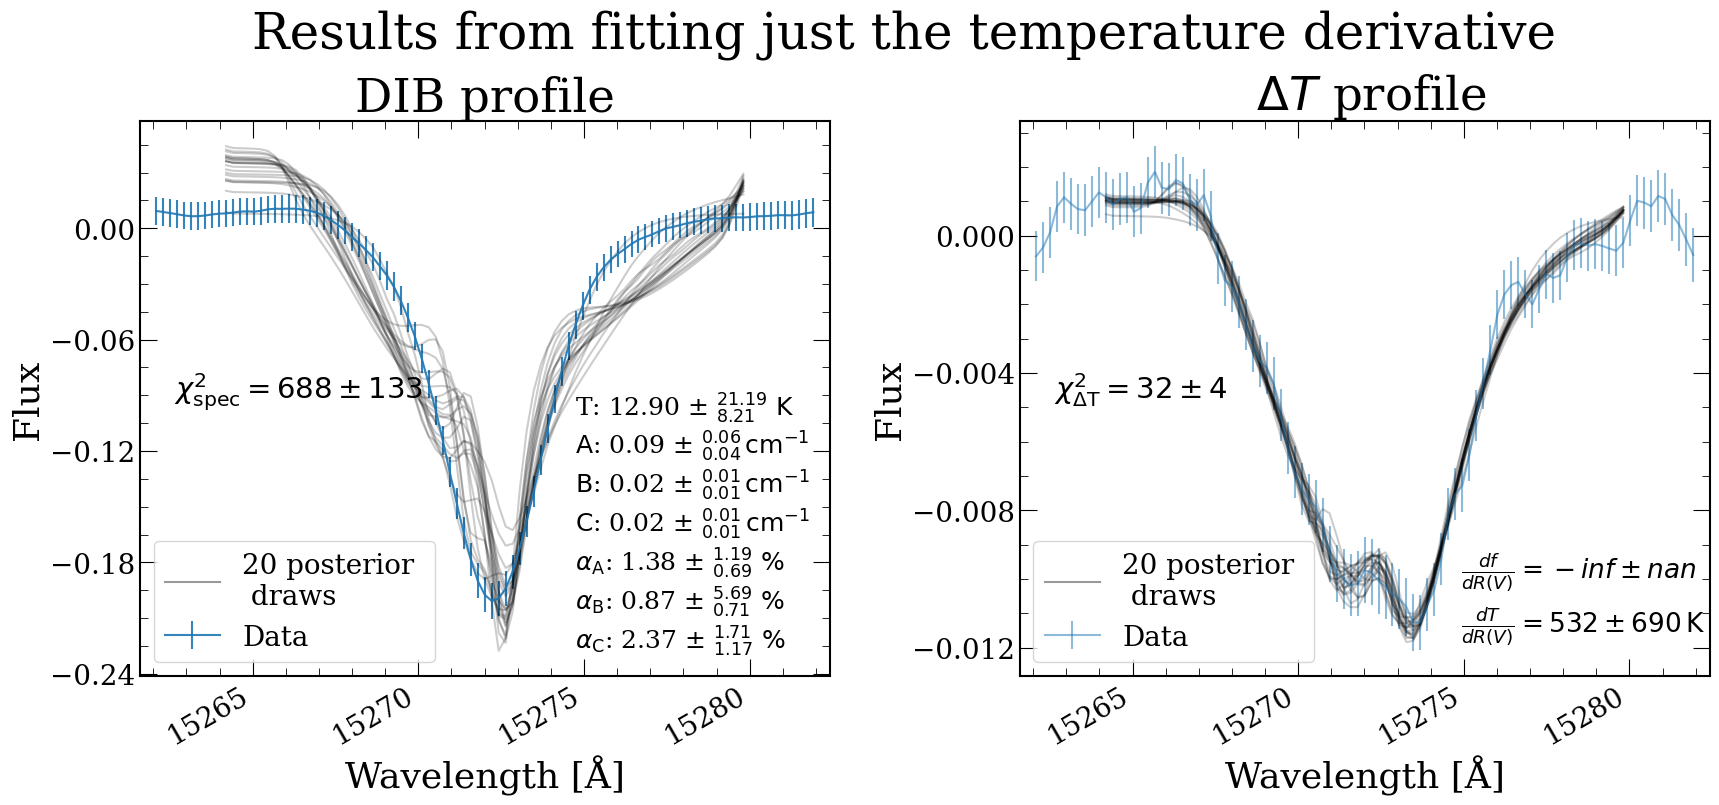

In [97]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=False)
plt.rc("font", family="serif",size= 28)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=26)
plt.rc("xtick", labelsize=20, direction="in")
plt.rc("ytick", labelsize=20, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=20)

plt.close('all')
fig, axs = plt.subplots(ncols = 2, figsize= (18,9))
c = 10

DIB_label = ''
posterior_label = f'{len(posterior_spectra)} posterior \n draws'

dwav = -0.5
xlim = (data_wavelength[0]+dwav, data_wavelength[-1]-dwav)
n_yticks = n_xticks = 5
legend_location = 'lower left'
alpha_post = 0.2

axs[0].errorbar(data_wavelength, data_flux, yerr = noise_std, alpha = 0.9, label = 'Data')
axs[0].plot(data_wavelength[c:-c], posterior_spectra.T, 'k-', alpha = alpha_post)
axs[0].plot(data_wavelength[c:-c]-100, posterior_spectra[0], 'k-', alpha = 2*alpha_post, label = posterior_label)

axs[0].set(xlabel = 'Wavelength [Å]', ylabel = 'Flux', title = 'DIB profile', xlim = xlim )
axs[0].legend(loc = legend_location)

axs[1].errorbar(data_wavelength, data_flux_dT, yerr = noise_std_dT, alpha = 0.5, label = 'Data')
axs[1].plot(data_wavelength[c:-c], posterior_dT.T, 'k-', alpha = alpha_post)
axs[1].plot(data_wavelength[c:-c]-100, posterior_dT[0], 'k-', alpha = 2*alpha_post, label = posterior_label)
axs[1].set(xlabel = 'Wavelength [Å]', ylabel = 'Flux', title = r' $\Delta T$ profile', xlim = xlim )
axs[1].legend(loc = legend_location)

plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

axs[0].xaxis.set_major_locator(plt.MaxNLocator(n_xticks))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(n_xticks))

axs[0].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))

labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T']
units = ['$~\mathrm{K}$']+[r'$\,\mathrm{cm}^{-1}$']*3+[r'$~\%$']*3
x0, y0 = 0.63, 0.47
dy = 0.07
for i, l in enumerate(labels[::-1]):
    s = np.copy(samples[inds,i])
    if i>3:
        s = (1-s)/2
        s*=100
    med = np.median(s)
    uperr = np.percentile(s, 84)-med
    downerr = med - np.percentile(s, 16)
    text = fr"{l}: {med:.2f} $\pm$ $^{{{uperr:.2f}}}_{{{downerr:.2f}}}$"+units[i]
    axs[0].annotate(text, xy = (x0, y0-i*dy), xycoords = 'axes fraction', fontsize = 18)

x0, y0 = 0.7, 0.47
dx = 0.06
dy = 0.065
i = 4.5
axs[1].annotate(fr'$\frac{{df}}{{dR(V)}} = {np.mean(dDIBdRV):.2f} \pm {np.std(dDIBdRV)/np.sqrt(len(dDIBdRV)):.2f}$', xy = (x0-dx, y0-i*dy), xycoords = 'axes fraction', fontsize = 19)
i = 6
axs[1].annotate(fr'$\frac{{dT}}{{dR(V)}} = {np.mean(beta_prime):.0f} \pm {np.std(beta_prime)/1:.0f}\,\mathrm{{K}}$', xy = (x0-dx, y0-i*dy), xycoords = 'axes fraction', fontsize = 19)


x0, y0 = 0.05, 0.5
dy = 0.09
fs = 21
annotate_total= False

chi2 = ( (posterior_spectra.T-data_flux[c:-c].reshape(-1, 1) )/noise_std[c:-c].reshape(-1, 1))**2
chi2 = np.sum(chi2, axis = 0)

chi2_dT = ( (posterior_dT.T-data_flux_dT[c:-c].reshape(-1, 1) )/noise_std_dT[c:-c].reshape(-1, 1))**2
chi2_dT = np.sum(chi2_dT, axis = 0)

divf = np.sqrt(len(chi2))
divf = 2

axs[0].annotate(fr'$\chi^2_{{\mathrm{{spec}}}} = {np.mean(chi2):.0f} \pm {np.std(chi2)/divf:.0f}$', xy = (x0, y0),\
                xycoords = 'axes fraction', fontsize = fs)
if annotate_total:
    axs[0].annotate(fr'$\chi^2_{{\mathrm{{tot}}}} = {np.mean(chi2+chi2_dT):.0f} \pm {np.std(chi2+chi2_dT)/divf:.0f}$', xy = (x0, y0-dy),\
                    xycoords = 'axes fraction', fontsize = fs)

axs[1].annotate(fr'$\chi^2_{{\mathrm{{\Delta T}}}} = {np.mean(chi2_dT):.0f} \pm {np.std(chi2_dT)/divf:.0f}$', xy = (x0, y0),\
                xycoords = 'axes fraction', fontsize = fs)
if annotate_total:
    axs[1].annotate(fr'$\chi^2_{{\mathrm{{tot}}}} = {np.mean(chi2+chi2_dT):.0f} \pm {np.std(chi2+chi2_dT)/divf:.0f}$', xy = (x0, y0-dy),\
                    xycoords = 'axes fraction', fontsize = fs)


title_add = ''
if args.fit_spec:
    title_add += 'the DIB profile'
    if args.fit_dT:
        title_add += ' AND the temperature derivative'
    else:
        title_add = 'just ' + title_add
if args.fit_dT and not args.fit_spec:
    title_add += 'just the temperature derivative'
    
fig.suptitle(f'Results from fitting {title_add}', y = 0.92, x = 0.52, fontsize = 36)

fig.tight_layout()
name = ''
if args.fit_spec:
    name += '_spec'
if args.fit_dT:
    name+='_dT'
fig.savefig(f'figs/data_and_model{name}.png', dpi = 200, bbox_inches = 'tight')

fig

/tmp/ipykernel_2756682/2306185737.py:2: RuntimeWarning: invalid value encountered in divide
  plt.hist( np.abs(blobs[:,0])/np.abs(blobs[:,1]), range = [0,10], bins =50 )


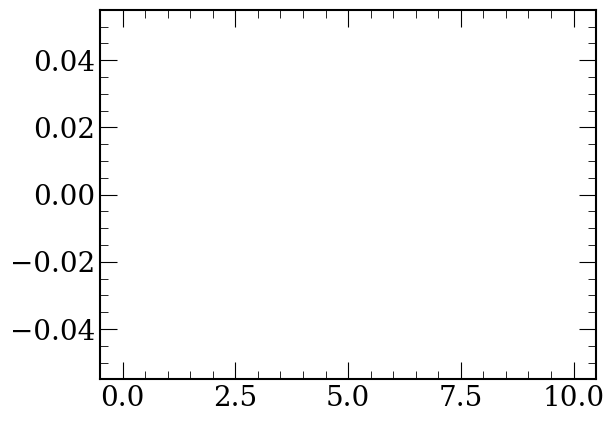

In [98]:
fig = plt.figure()
plt.hist( np.abs(blobs[:,0])/np.abs(blobs[:,1]), range = [0,10], bins =50 )
fig

Samples shape: (25600, 7)


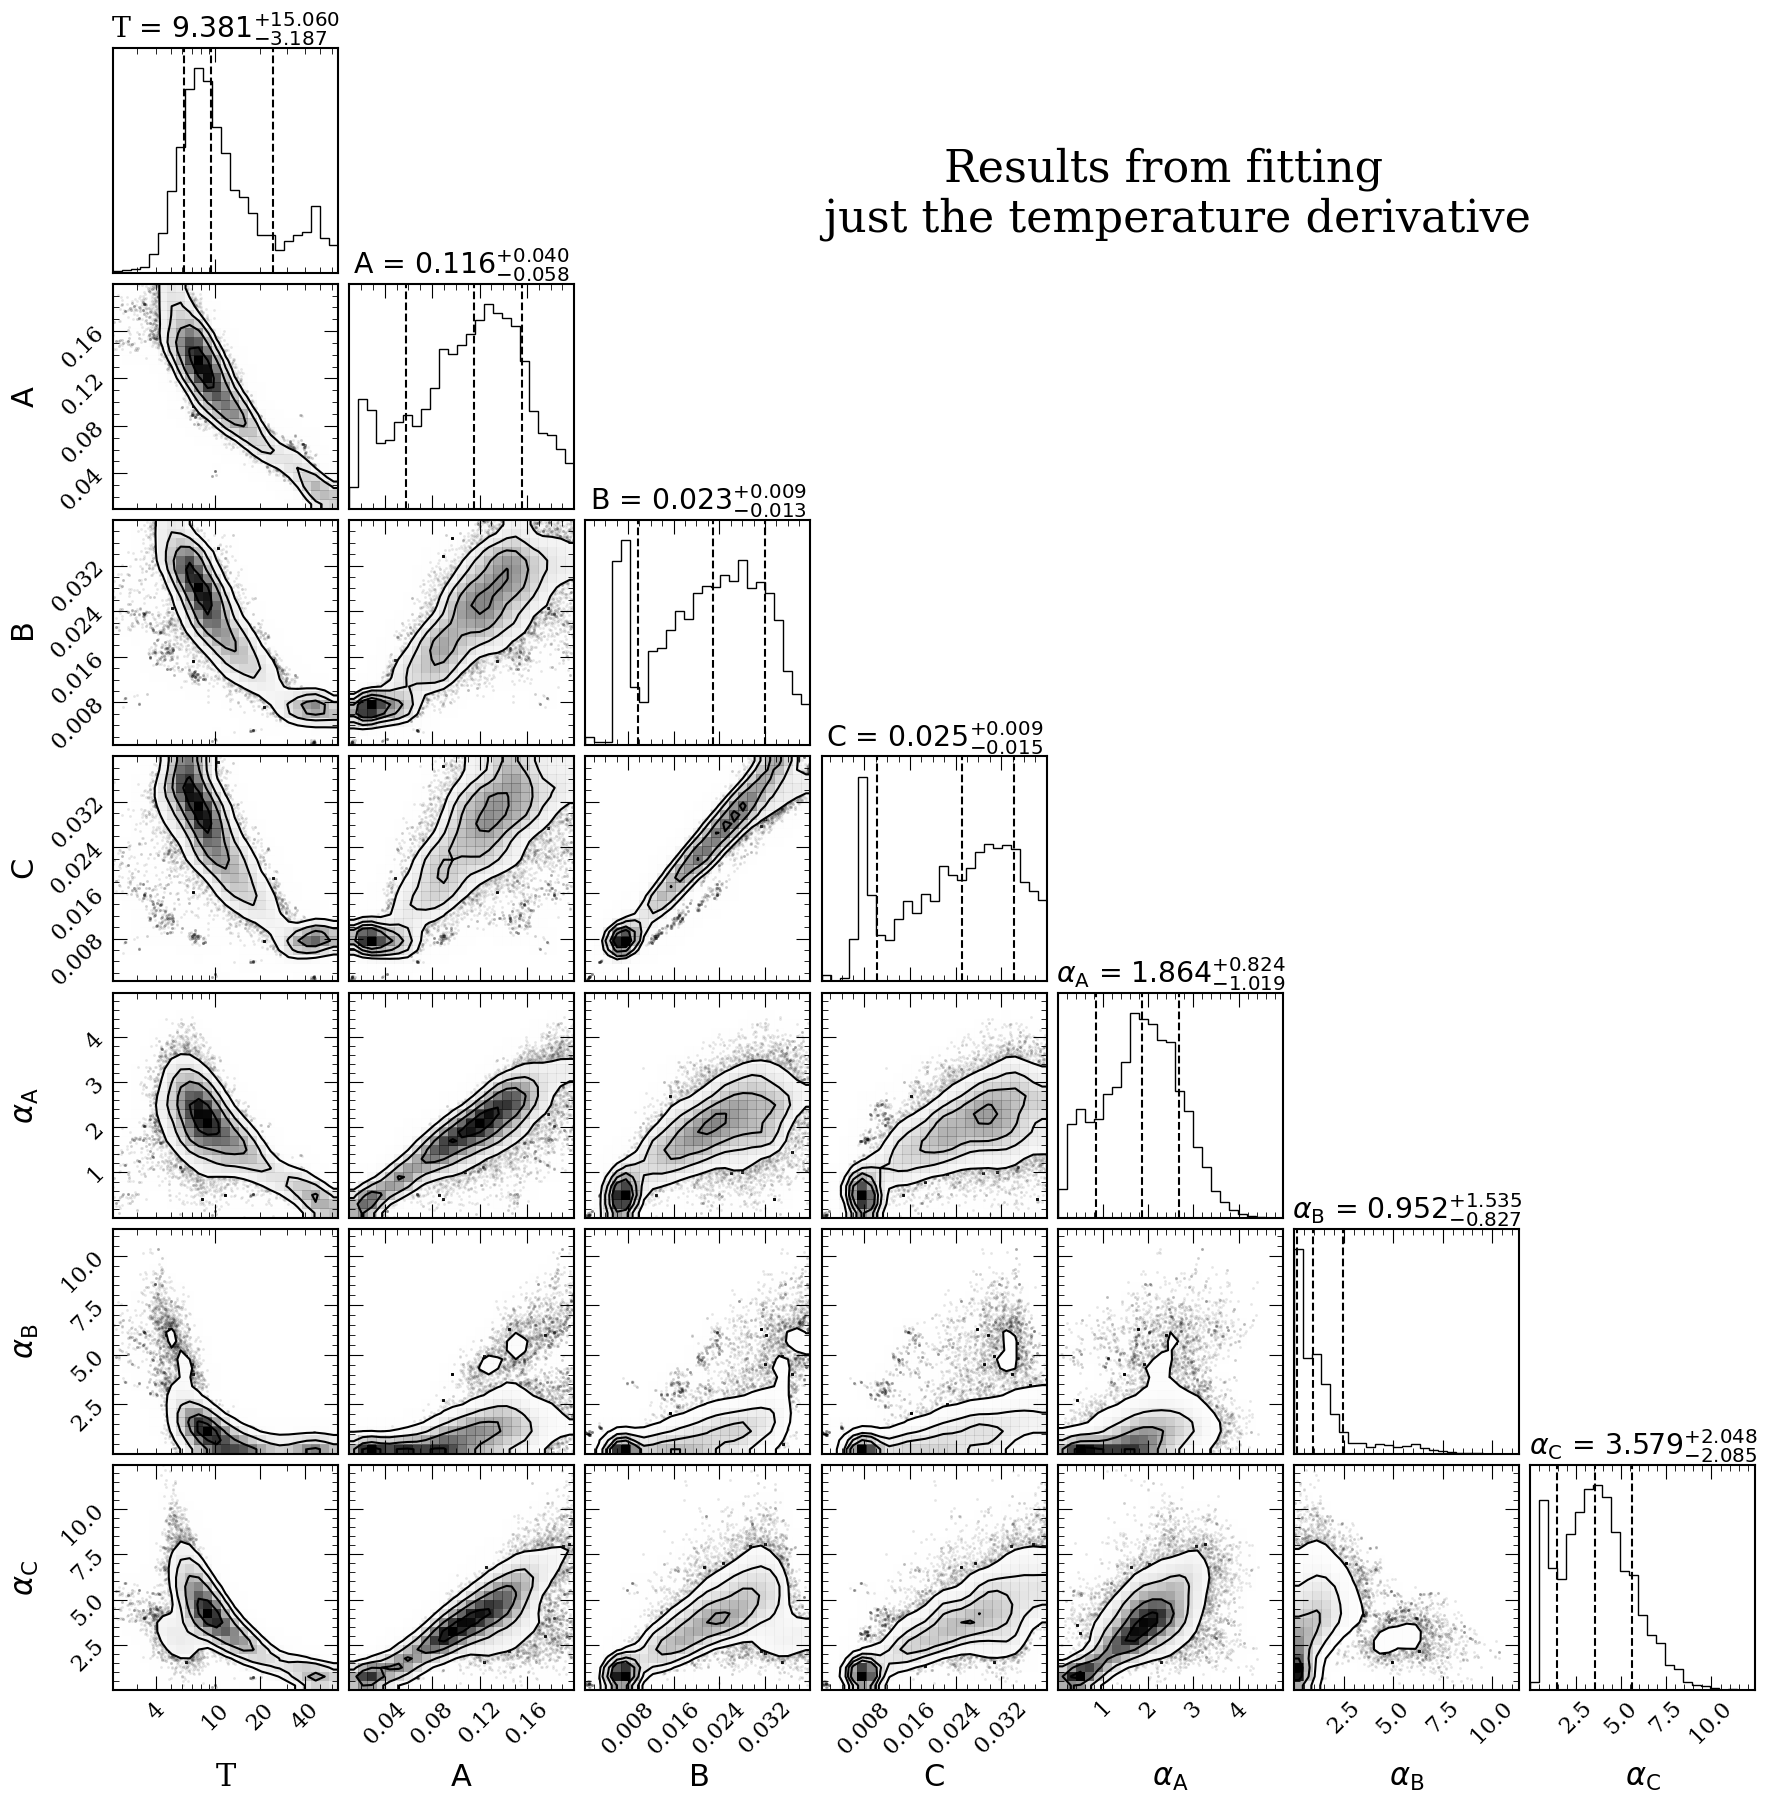

In [103]:
from matplotlib.ticker import LogLocator, FuncFormatter
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=False)
plt.rc("font", family="serif",size= 17)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=22)
plt.rc("xtick", labelsize=16, direction="in")
plt.rc("ytick", labelsize=16, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=10, pad=6)
plt.rc("xtick.minor",size=4, pad=6)
plt.rc("ytick.major",size=10)
plt.rc("ytick.minor",size=4)
plt.rc("legend", fontsize=20)

# samples_ext = samples[samples[:,0]>10]
# samples = np.vstack([samples, samples_ext, samples_ext, samples_ext])
print(f"Samples shape: {samples.shape}")

labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T']
# Corner plot

samples0 = np.copy(samples)
samples0[:,[4,5,6]] = (1-samples0[:,[4,5,6]])/2*100
axes_scale = ['log']+6*['linear']
# axes_scale = 7*['linear']

fig, axs = plt.subplots(7, 7, figsize = ( 18, 18 )) 

fig = corner.corner(
    samples0,
    labels=labels[::-1],
    bins = 25,
    axes_scale = axes_scale,
    show_titles=True,
    smooth = 1,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    range = [0.999999]*len(labels),
    use_math_text = True,
    labelpad = 0.02,
    fig = fig
)

# for ax in fig.get_axes():
#     for label in ax.get_xticklabels():
#         label.set_rotation(10)



# Target the correct axis (here, axis #6, which is the bottom-left corner for param 0)
ax = fig.axes[-7]

# Choose your desired tick positions in linear space
if args.fit_spec:
    tick_positions = [3, 4, 6, 10, 17]
    if args.fit_dT:
        tick_positions = [3, 4, 6, 10, 13]    
        
if args.fit_dT and not args.fit_spec:
    tick_positions = [4, 10, 20, 40]    
    
# Apply to log-scaled axis using LogLocator and manually set labels
ax.set_xticks(tick_positions)
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))

fig.suptitle(f'Results from fitting \n {title_add}', y = 0.92, x = 0.65, fontsize = 32)

plt.draw()
name = ''
if args.fit_spec:
    name += '_spec'
if args.fit_dT:
    name+='_dT'
fig.savefig(f'figs/emcee{name}.png', dpi = 200, bbox_inches = 'tight')
fig

In [35]:
ax

<Axes: >

In [95]:
list_fits = os.listdir('temp_outputs')
list_fits = [l[-9:-4] for l in list_fits]

idx = 10

spec = np.loadtxt(f'temp_outputs/fit_spec_{list_fits[idx]}.csv')
spec, specb, specc, dT, dTb, dTc = spec
# specb = np.loadtxt(f'temp_outputs/specb_{list_fits[idx]}.csv')
# specc = np.loadtxt(f'temp_outputs/specc_{list_fits[idx]}.csv')
# dT = np.loadtxt(f'temp_outputs/fit_dt_{list_fits[idx]}.csv')


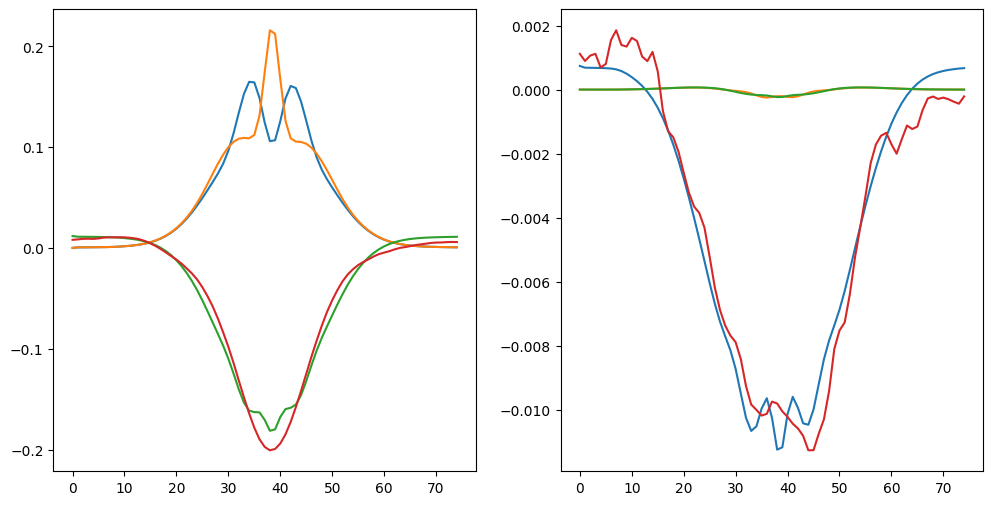

In [103]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6))
c = 10
axs[0].plot(specb)

axs[0].plot(specc)
axs[0].plot(spec)
axs[0].plot(data_flux[c:-c])

axs[1].plot(dT)
axs[1].plot(dTb)
axs[1].plot(dTc)
axs[1].plot(data_flux_dT[c:-c])
